In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

torch.manual_seed(42)

In [2]:
dataset = pd.read_csv('/scratchdata/stock/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
all_data = dataset.iloc[:,1:2].values
sc = MinMaxScaler(feature_range=(0,1))
all_data = sc.fit_transform(all_data)

np.random.shuffle(all_data)


RATIO = 0.8

train_data = all_data[:int(len(all_data)*RATIO)]   
test_data = all_data[int(len(all_data)*RATIO):]

In [5]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len(train_data)-1):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
#y_train = np.reshape(y_train, (y_train.shape[0],y_train.shape[1],1))

train_dataloader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)), batch_size=32, shuffle=True)

X_test = []
y_test = []
for i in range(60,len(test_data)-1):
    X_test.append(test_data[i-60:i,0])
    y_test.append(test_data[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

test_dataloader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)), batch_size=32, shuffle=True)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature_size = 1
hidden_size = 100 # This is 
dropout = 0.2

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = torch.nn.LSTM(feature_size, hidden_size, 3, batch_first=True, dropout=dropout)
        self.linear = torch.nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        #x = x.reshape(-1, x.shape[1], 1)
        x = x[:,-1] # Selects for last feature
        return x

model = Model().to(device) 
# Inputs: B x S x F
# B - batch size
# S - sequence length
# F - feature size

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
for epoch in range(1):
    model.train()
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)

    print(f'Loss: {loss.item()}')



100%|██████████| 74/74 [00:00<00:00, 267.95it/s]


Loss: 0.06740108877420425


100%|██████████| 74/74 [00:00<00:00, 299.16it/s]


Loss: 0.07888276875019073


100%|██████████| 74/74 [00:00<00:00, 272.84it/s]


Loss: 0.07370054721832275


100%|██████████| 74/74 [00:00<00:00, 304.72it/s]


Loss: 0.06944964081048965


100%|██████████| 74/74 [00:00<00:00, 302.23it/s]


Loss: 0.10654663294553757


100%|██████████| 74/74 [00:00<00:00, 305.42it/s]


Loss: 0.09350521117448807


100%|██████████| 74/74 [00:00<00:00, 281.64it/s]


Loss: 0.07732962816953659


100%|██████████| 74/74 [00:00<00:00, 270.49it/s]


Loss: 0.08129232376813889


100%|██████████| 74/74 [00:00<00:00, 290.89it/s]


Loss: 0.040213290601968765


100%|██████████| 74/74 [00:00<00:00, 296.44it/s]


Loss: 0.07316111028194427


100%|██████████| 74/74 [00:00<00:00, 307.18it/s]


Loss: 0.08916792273521423


100%|██████████| 74/74 [00:00<00:00, 304.45it/s]


Loss: 0.06411167234182358


100%|██████████| 74/74 [00:00<00:00, 300.41it/s]


Loss: 0.07578162103891373


100%|██████████| 74/74 [00:00<00:00, 288.40it/s]


Loss: 0.0725625529885292


100%|██████████| 74/74 [00:00<00:00, 310.66it/s]


Loss: 0.0649145171046257


100%|██████████| 74/74 [00:00<00:00, 309.98it/s]


Loss: 0.07132893800735474


100%|██████████| 74/74 [00:00<00:00, 271.72it/s]


Loss: 0.06374380737543106


100%|██████████| 74/74 [00:00<00:00, 311.84it/s]


Loss: 0.051842495799064636


100%|██████████| 74/74 [00:00<00:00, 312.90it/s]


Loss: 0.08078501373529434


100%|██████████| 74/74 [00:00<00:00, 294.52it/s]


Loss: 0.07001586258411407


100%|██████████| 74/74 [00:00<00:00, 312.92it/s]


Loss: 0.058217260986566544


100%|██████████| 74/74 [00:00<00:00, 301.74it/s]


Loss: 0.08049535751342773


100%|██████████| 74/74 [00:00<00:00, 260.33it/s]


Loss: 0.09363669157028198


100%|██████████| 74/74 [00:00<00:00, 291.51it/s]


Loss: 0.06215530261397362


100%|██████████| 74/74 [00:00<00:00, 257.41it/s]


Loss: 0.0902315154671669


100%|██████████| 74/74 [00:00<00:00, 296.38it/s]


Loss: 0.06135772168636322


100%|██████████| 74/74 [00:00<00:00, 280.54it/s]


Loss: 0.07471758872270584


100%|██████████| 74/74 [00:00<00:00, 306.00it/s]


Loss: 0.05883537977933884


100%|██████████| 74/74 [00:00<00:00, 313.12it/s]


Loss: 0.09753693640232086


100%|██████████| 74/74 [00:00<00:00, 307.20it/s]


Loss: 0.09685767441987991


100%|██████████| 74/74 [00:00<00:00, 299.40it/s]


Loss: 0.07937555760145187


100%|██████████| 74/74 [00:00<00:00, 303.73it/s]


Loss: 0.07627501338720322


100%|██████████| 74/74 [00:00<00:00, 307.03it/s]


Loss: 0.049496863037347794


100%|██████████| 74/74 [00:00<00:00, 291.60it/s]


Loss: 0.07928936928510666


100%|██████████| 74/74 [00:00<00:00, 281.02it/s]


Loss: 0.10437716543674469


100%|██████████| 74/74 [00:00<00:00, 297.57it/s]


Loss: 0.09004974365234375


100%|██████████| 74/74 [00:00<00:00, 293.91it/s]


Loss: 0.057593896985054016


100%|██████████| 74/74 [00:00<00:00, 293.13it/s]


Loss: 0.11404383927583694


100%|██████████| 74/74 [00:00<00:00, 297.44it/s]


Loss: 0.07098208367824554


100%|██████████| 74/74 [00:00<00:00, 289.50it/s]


Loss: 0.05744839459657669


100%|██████████| 74/74 [00:00<00:00, 258.86it/s]


Loss: 0.07869186252355576


100%|██████████| 74/74 [00:00<00:00, 301.07it/s]


Loss: 0.06582628190517426


100%|██████████| 74/74 [00:00<00:00, 268.67it/s]


Loss: 0.07392331212759018


100%|██████████| 74/74 [00:00<00:00, 278.13it/s]


Loss: 0.08477439731359482


100%|██████████| 74/74 [00:00<00:00, 285.35it/s]


Loss: 0.05749978497624397


100%|██████████| 74/74 [00:00<00:00, 301.67it/s]


Loss: 0.07598806172609329


100%|██████████| 74/74 [00:00<00:00, 282.00it/s]


Loss: 0.0914401039481163


100%|██████████| 74/74 [00:00<00:00, 291.19it/s]


Loss: 0.07125114649534225


100%|██████████| 74/74 [00:00<00:00, 302.20it/s]


Loss: 0.07279404997825623


100%|██████████| 74/74 [00:00<00:00, 292.04it/s]


Loss: 0.08034167438745499


100%|██████████| 74/74 [00:00<00:00, 282.74it/s]


Loss: 0.10422705113887787


100%|██████████| 74/74 [00:00<00:00, 296.21it/s]


Loss: 0.08577638864517212


100%|██████████| 74/74 [00:00<00:00, 305.18it/s]


Loss: 0.07150328159332275


100%|██████████| 74/74 [00:00<00:00, 298.19it/s]


Loss: 0.06167813017964363


100%|██████████| 74/74 [00:00<00:00, 286.57it/s]


Loss: 0.08450404554605484


100%|██████████| 74/74 [00:00<00:00, 308.28it/s]


Loss: 0.06996478885412216


100%|██████████| 74/74 [00:00<00:00, 308.34it/s]


Loss: 0.06716740876436234


100%|██████████| 74/74 [00:00<00:00, 298.73it/s]


Loss: 0.0741262286901474


100%|██████████| 74/74 [00:00<00:00, 301.63it/s]


Loss: 0.06279182434082031


100%|██████████| 74/74 [00:00<00:00, 249.96it/s]


Loss: 0.08840520679950714


100%|██████████| 74/74 [00:00<00:00, 290.80it/s]


Loss: 0.09192116558551788


100%|██████████| 74/74 [00:00<00:00, 300.48it/s]


Loss: 0.05769174173474312


100%|██████████| 74/74 [00:00<00:00, 300.81it/s]


Loss: 0.06606084108352661


100%|██████████| 74/74 [00:00<00:00, 299.44it/s]


Loss: 0.10579659789800644


100%|██████████| 74/74 [00:00<00:00, 285.60it/s]


Loss: 0.06944373995065689


100%|██████████| 74/74 [00:00<00:00, 297.79it/s]


Loss: 0.08150860667228699


100%|██████████| 74/74 [00:00<00:00, 298.57it/s]


Loss: 0.09368494153022766


100%|██████████| 74/74 [00:00<00:00, 291.57it/s]


Loss: 0.06362251937389374


100%|██████████| 74/74 [00:00<00:00, 289.88it/s]


Loss: 0.06804961711168289


100%|██████████| 74/74 [00:00<00:00, 292.64it/s]


Loss: 0.09789595752954483


100%|██████████| 74/74 [00:00<00:00, 308.26it/s]


Loss: 0.07116376608610153


100%|██████████| 74/74 [00:00<00:00, 283.66it/s]


Loss: 0.0727393701672554


100%|██████████| 74/74 [00:00<00:00, 300.72it/s]


Loss: 0.06911079585552216


100%|██████████| 74/74 [00:00<00:00, 299.11it/s]


Loss: 0.09363407641649246


100%|██████████| 74/74 [00:00<00:00, 300.77it/s]


Loss: 0.10875155031681061


100%|██████████| 74/74 [00:00<00:00, 280.73it/s]


Loss: 0.06696970760822296


100%|██████████| 74/74 [00:00<00:00, 308.83it/s]


Loss: 0.06979409605264664


100%|██████████| 74/74 [00:00<00:00, 300.06it/s]


Loss: 0.08504773676395416


100%|██████████| 74/74 [00:00<00:00, 281.13it/s]


Loss: 0.08815337717533112


100%|██████████| 74/74 [00:00<00:00, 284.83it/s]


Loss: 0.09073268622159958


100%|██████████| 74/74 [00:00<00:00, 289.54it/s]


Loss: 0.0793919712305069


100%|██████████| 74/74 [00:00<00:00, 297.50it/s]


Loss: 0.06800723820924759


100%|██████████| 74/74 [00:00<00:00, 304.75it/s]


Loss: 0.07427612692117691


100%|██████████| 74/74 [00:00<00:00, 259.48it/s]


Loss: 0.07911887019872665


100%|██████████| 74/74 [00:00<00:00, 302.84it/s]


Loss: 0.06413248926401138


100%|██████████| 74/74 [00:00<00:00, 301.68it/s]


Loss: 0.08809798955917358


100%|██████████| 74/74 [00:00<00:00, 301.57it/s]


Loss: 0.07500368356704712


100%|██████████| 74/74 [00:00<00:00, 305.19it/s]


Loss: 0.08670574426651001


100%|██████████| 74/74 [00:00<00:00, 310.76it/s]


Loss: 0.09649773687124252


100%|██████████| 74/74 [00:00<00:00, 301.02it/s]


Loss: 0.05060888081789017


100%|██████████| 74/74 [00:00<00:00, 305.75it/s]


Loss: 0.07066895812749863


100%|██████████| 74/74 [00:00<00:00, 298.92it/s]


Loss: 0.07326512038707733


100%|██████████| 74/74 [00:00<00:00, 284.05it/s]


Loss: 0.09709993004798889


100%|██████████| 74/74 [00:00<00:00, 305.50it/s]


Loss: 0.0747925192117691


100%|██████████| 74/74 [00:00<00:00, 303.57it/s]


Loss: 0.058640990406274796


100%|██████████| 74/74 [00:00<00:00, 294.03it/s]


Loss: 0.09037977457046509


100%|██████████| 74/74 [00:00<00:00, 302.76it/s]


Loss: 0.1091424971818924


100%|██████████| 74/74 [00:00<00:00, 301.89it/s]


Loss: 0.0668296292424202


100%|██████████| 74/74 [00:00<00:00, 301.37it/s]


Loss: 0.06887032836675644


100%|██████████| 74/74 [00:00<00:00, 285.62it/s]

Loss: 0.08214625716209412


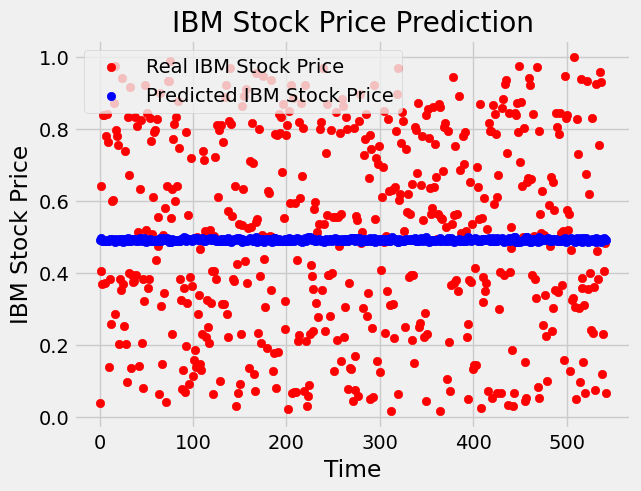

In [10]:
# Plot estimate against actual
model.eval()
with torch.no_grad():
    y_pred = model(torch.Tensor(X_test).to(device)).cpu().numpy()

plt.scatter(range(len(y_test)), y_test, color='red', label='Real IBM Stock Price')
plt.scatter(range(len(y_pred)), y_pred, color='blue', label='Predicted IBM Stock Price')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.show()